## import

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math

import seaborn as sns
import pandas as pd
import librosa
import librosa.display
try:
    from dtw import dtw
except:
    !pip install dtw
    from dtw import dtw


try:
    from pydub import AudioSegment
except:
    !pip install pydub
    from pydub import AudioSegment

## Selection aléatoire de quelques drums

In [24]:
def quoiChoose(p, interval):
    res = []
    N = (interval[1] - interval[0])+1
    cb = int(N*p)

    tab = list(range(interval[0],interval[1]+1))
    print(tab)
    while len(res) < cb:
        c = random.choice(tab)
        if c not in res:
            res.append(c)
    return res

quoiChoose( 0.1, [1,40] )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


[5, 14, 15, 11]

## Choix du drumkit 

In [80]:
def CreerDossierSauvegarde(ou,doss):
    nomEmplacementSauvegarde = ou + "/" + doss
    if not os.path.exists(nomEmplacementSauvegarde):
        os.mkdir(nomEmplacementSauvegarde)
        return nomEmplacementSauvegarde
    else:
        return nomEmplacementSauvegarde


In [81]:
# Le dossier de sauvegarde DRIVE
from google.colab import drive,files
drive.mount('/content/gdrive')
!ls /content

DRIVE_LEDOSSIER = "/content/gdrive/Shareddrives/# Zone de Code #/• Wanabilini The Producer TOOLS"

DRIVE_LEDOSSIER = CreerDossierSauvegarde(DRIVE_LEDOSSIER ,"backups")

DRUMKIT_LEDOSSIER = "/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/prodbyjack - THEDRUMCOLLECTION/Dancehall"

print(os.listdir(DRUMKIT_LEDOSSIER))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
['Perc', 'Open Hat', 'Kick', 'Hi Hat', 'Fx', 'Clap', '808', 'Snare']


In [82]:

def get_all_directory(kit_path, res = []):
    if os.path.exists(str(kit_path)):
        for fic in os.listdir(kit_path):
            fic = kit_path + "/" + fic
            if os.path.isdir(fic): #si dossier
                res.append(fic)
                res = get_all_directory(fic,res)
                #print(fic)
    return res

all_dossier_a_analyser_DRUMKIT = get_all_directory(DRUMKIT_LEDOSSIER)

def get_names_files_on(doss):
    listeFichiersAUDIO_names = np.array([f"[{i}] " +  fic for i,fic in enumerate(os.listdir(doss)) if fic.split(".")[-1] in ["mp3", "wav"]  ])
    listeFichiersAUDIO =  np.array([doss + "/" + fic for fic in os.listdir(doss) if fic.split(".")[-1] in ["mp3", "wav"]  ])
    return listeFichiersAUDIO_names, listeFichiersAUDIO 

print(get_names_files_on(all_dossier_a_analyser_DRUMKIT[3] ) [0])


['[0] [PS] Perc-ish Hi Hat (dancehall).wav'
 '[1] [PS] Open Hi Hat (dancehall).wav'
 '[2] [PS] New Hi Hat (dancehall).wav'
 '[3] [PS] Shake Hi Hat (dancehall).wav'
 '[4] [PS] Low Hi Hat (dancehall).wav'
 '[5] [PS] Heavy Hi Hat (dancehall).wav'
 '[6] [PS] Harsh Hi Hat (dancehall).wav'
 '[7] [PS] Go-to Hi Hat (dancehall).wav'
 '[8] [PS] Cym Hi Hat (dancehall).wav'
 '[9] [PS] Unique Hi Hat (dancehall).wav'
 '[10] [PS] Short Hi Hat (dancehall).wav'
 '[11] [PS] Tight Hi Hat (dancehall).wav'
 '[12] [PS] Sharp Hi Hat (dancehall).wav'
 '[13] [PS] Shaker Hi Hat (dancehall).wav'
 '[14] [PS] Caan Hi Hat (dancehall).wav'
 '[15] [PS] Breathe Hi Hat (dancehall).wav']


## Test • Comparer 2 audios

In [83]:
one_seconds = 1000

listeFichiersAUDIO = get_names_files_on(all_dossier_a_analyser_DRUMKIT[0] ) [1]
file1 = listeFichiersAUDIO[1]
file2 = listeFichiersAUDIO[2]


def AfficherAudio(filename_list, cut_sec):
    if filename_list:
        song = AudioSegment.from_wav(filename_list[0])[0:one_seconds* cut_sec]
        if len(filename_list) > 1:
            for f in filename_list[1:]:
                song += AudioSegment.from_wav(f)[0:one_seconds* cut_sec]

    return song

AfficherAudio([file1,file2],3)

Normalized distance between the two sounds: 12758.761657714844


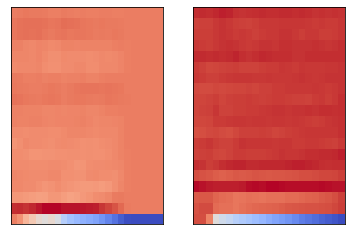

In [84]:
#Loading audio files
y1, sr1 = librosa.load(file1) 
y2, sr2 = librosa.load(file2) 

#Showing multiple plots using subplot
plt.subplot(1, 2, 1) 
mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
librosa.display.specshow(mfcc1)

plt.subplot(1, 2, 2)
mfcc2 = librosa.feature.mfcc(y2, sr2)
librosa.display.specshow(mfcc2)

from numpy.linalg import norm
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist )  # 0 for similar audios 

(-0.5, 22.5)

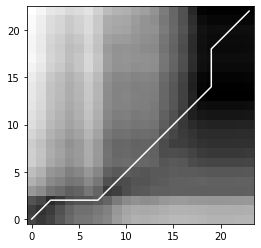

In [85]:
plt.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w') #creating plot for DTW
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

## Test • Comparer un dossier d'audios

In [86]:
%%time

def distance_entre_2_audios(file1,file2):
    #Loading audio files
    y1, sr1 = librosa.load(file1) 
    y2, sr2 = librosa.load(file2) 

    mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
    mfcc2 = librosa.feature.mfcc(y2, sr2)

    dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
    return dist

distance_entre_2_audios(file1,file2)

CPU times: user 71.5 ms, sys: 17.4 ms, total: 88.9 ms
Wall time: 77.1 ms


In [88]:
def matrice_similitude_listes_audios( l_audios):
    N = len(l_audios)
    tab = np.empty((N,N))
    tab[:] = np.NaN

    for i,fic1 in enumerate(l_audios):
        for j,fic2 in enumerate(l_audios):
            if j < i:
                tab[i][j] = distance_entre_2_audios(fic1,fic2)
            print(f"{int((i/len(l_audios))*100)}%", end="")
    return tab

In [98]:
def CreateHeatMap(tab_dist, col_names ,title):
    df = pd.DataFrame(tab_dist, columns= col_names,index= col_names)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(32,32))  
        plt.title(title, fontsize=20)
        ax = sns.heatmap(df,linewidths=.1)
    figure = ax.get_figure()  
    figure.savefig(DRIVE_LEDOSSIER+"/"+title+".png", dpi=400)
    plt.show()

## -> Comparer un drumkit entier

# prodbyjack - THEDRUMCOLLECTION-Dancehall-Perc
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%15%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22%22%22%22%22%22%22%22%22%22%22

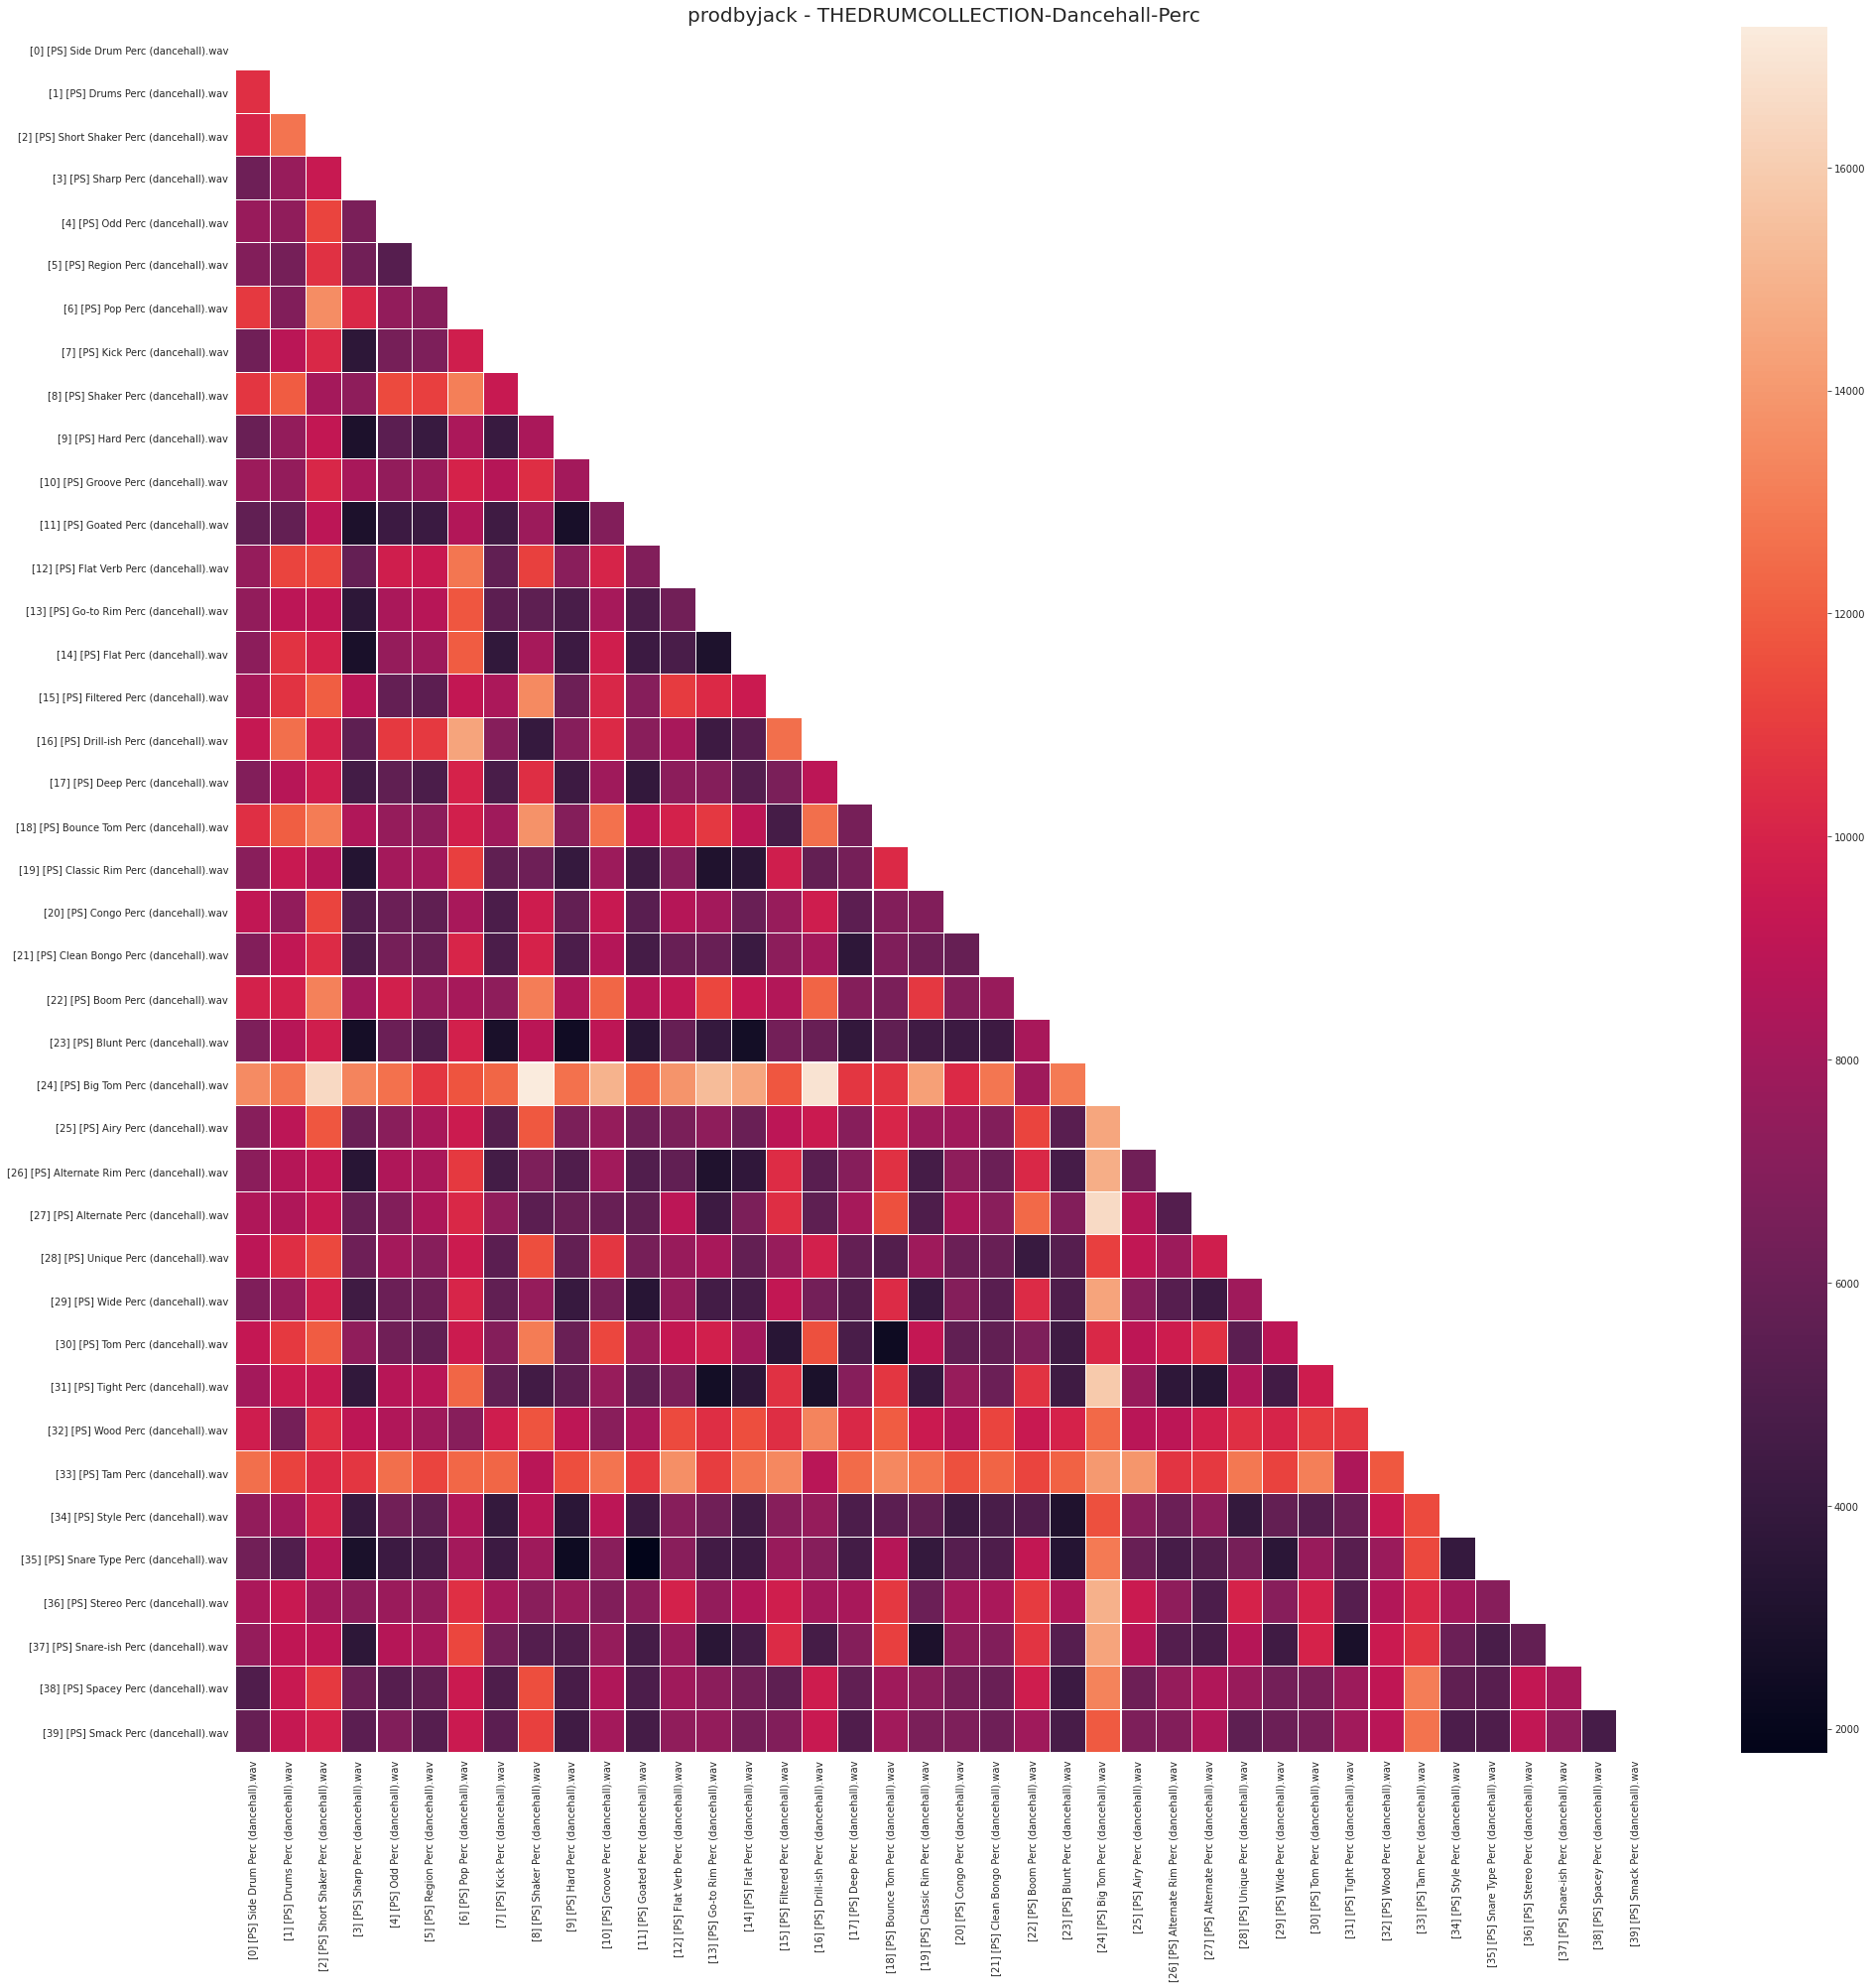

# prodbyjack - THEDRUMCOLLECTION-Dancehall-Open Hat
0%0%0%0%0%0%0%0%0%11%11%11%11%11%11%11%11%11%22%22%22%22%22%22%22%22%22%33%33%33%33%33%33%33%33%33%44%44%44%44%44%44%44%44%44%55%55%55%55%55%55%55%55%55%66%66%66%66%66%66%66%66%66%77%77%77%77%77%77%77%77%77%88%88%88%88%88%88%88%88%88%

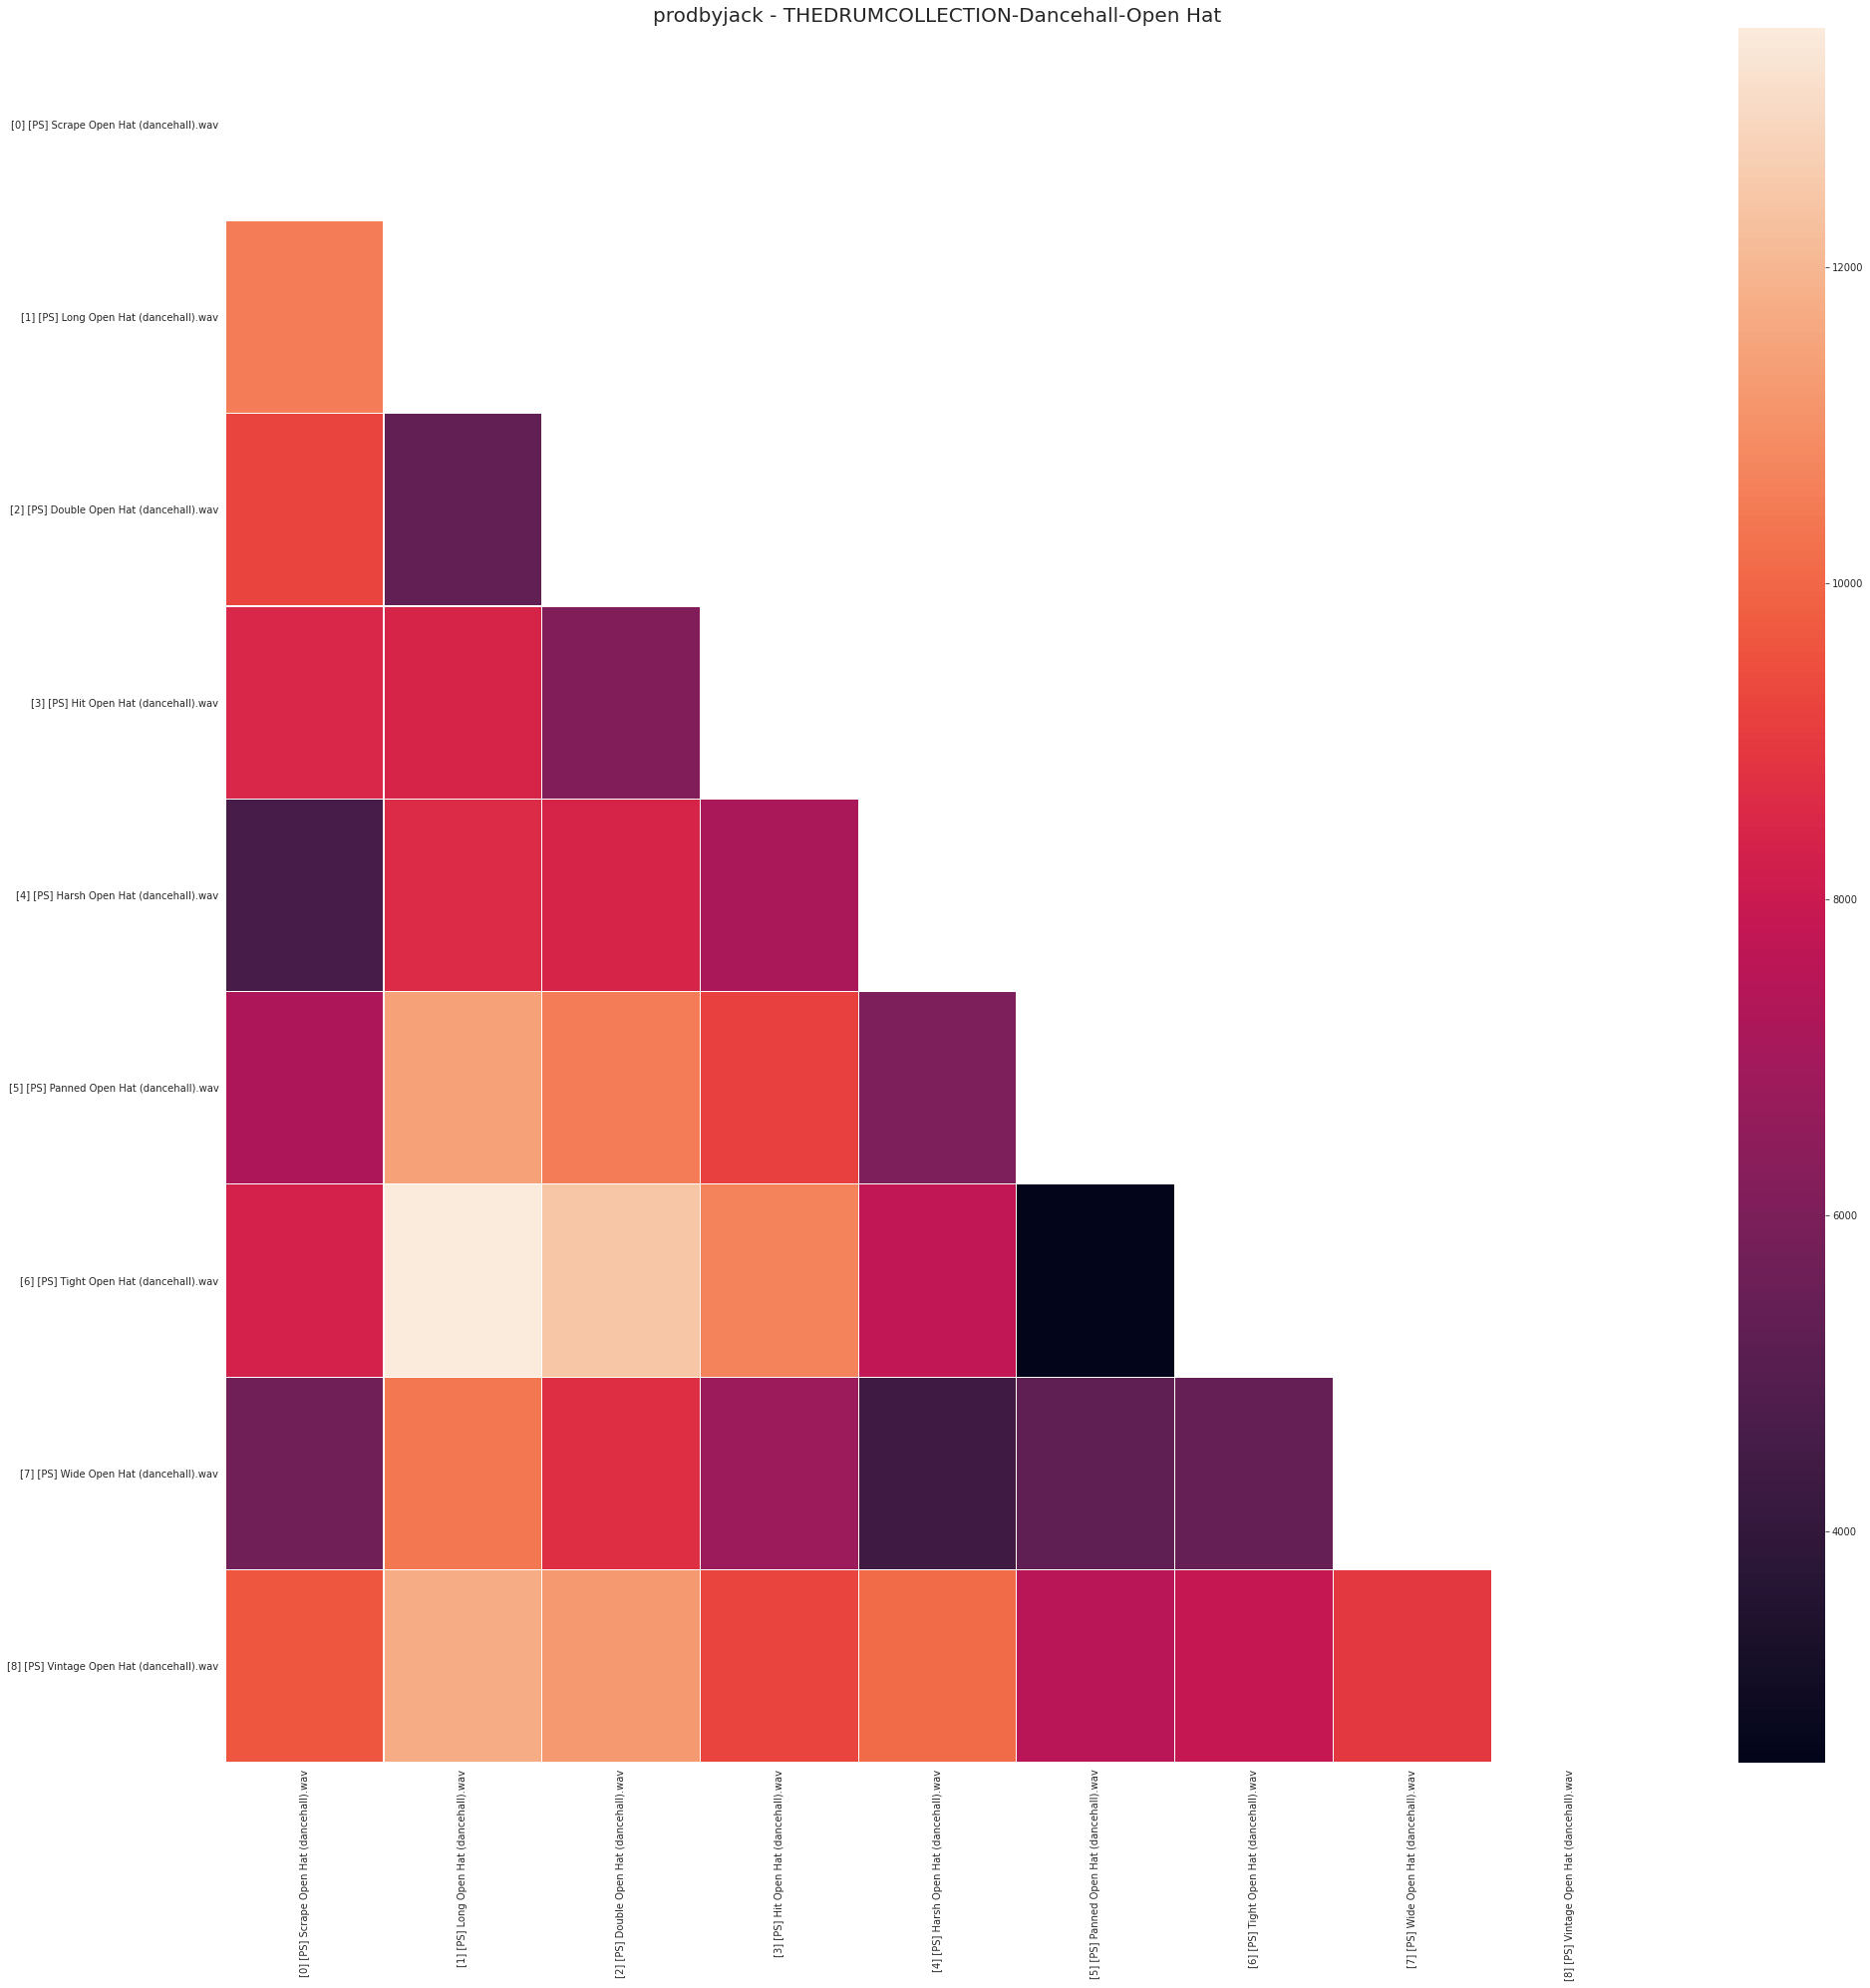

# prodbyjack - THEDRUMCOLLECTION-Dancehall-Kick
0%0%0%0%0%0%0%0%0%11%11%11%11%11%11%11%11%11%22%22%22%22%22%22%22%22%22%33%33%33%33%33%33%33%33%33%44%44%44%44%44%44%44%44%44%55%55%55%55%55%55%55%55%55%66%66%66%66%66%66%66%66%66%77%77%77%77%77%77%77%77%77%88%88%88%88%88%88%88%88%88%

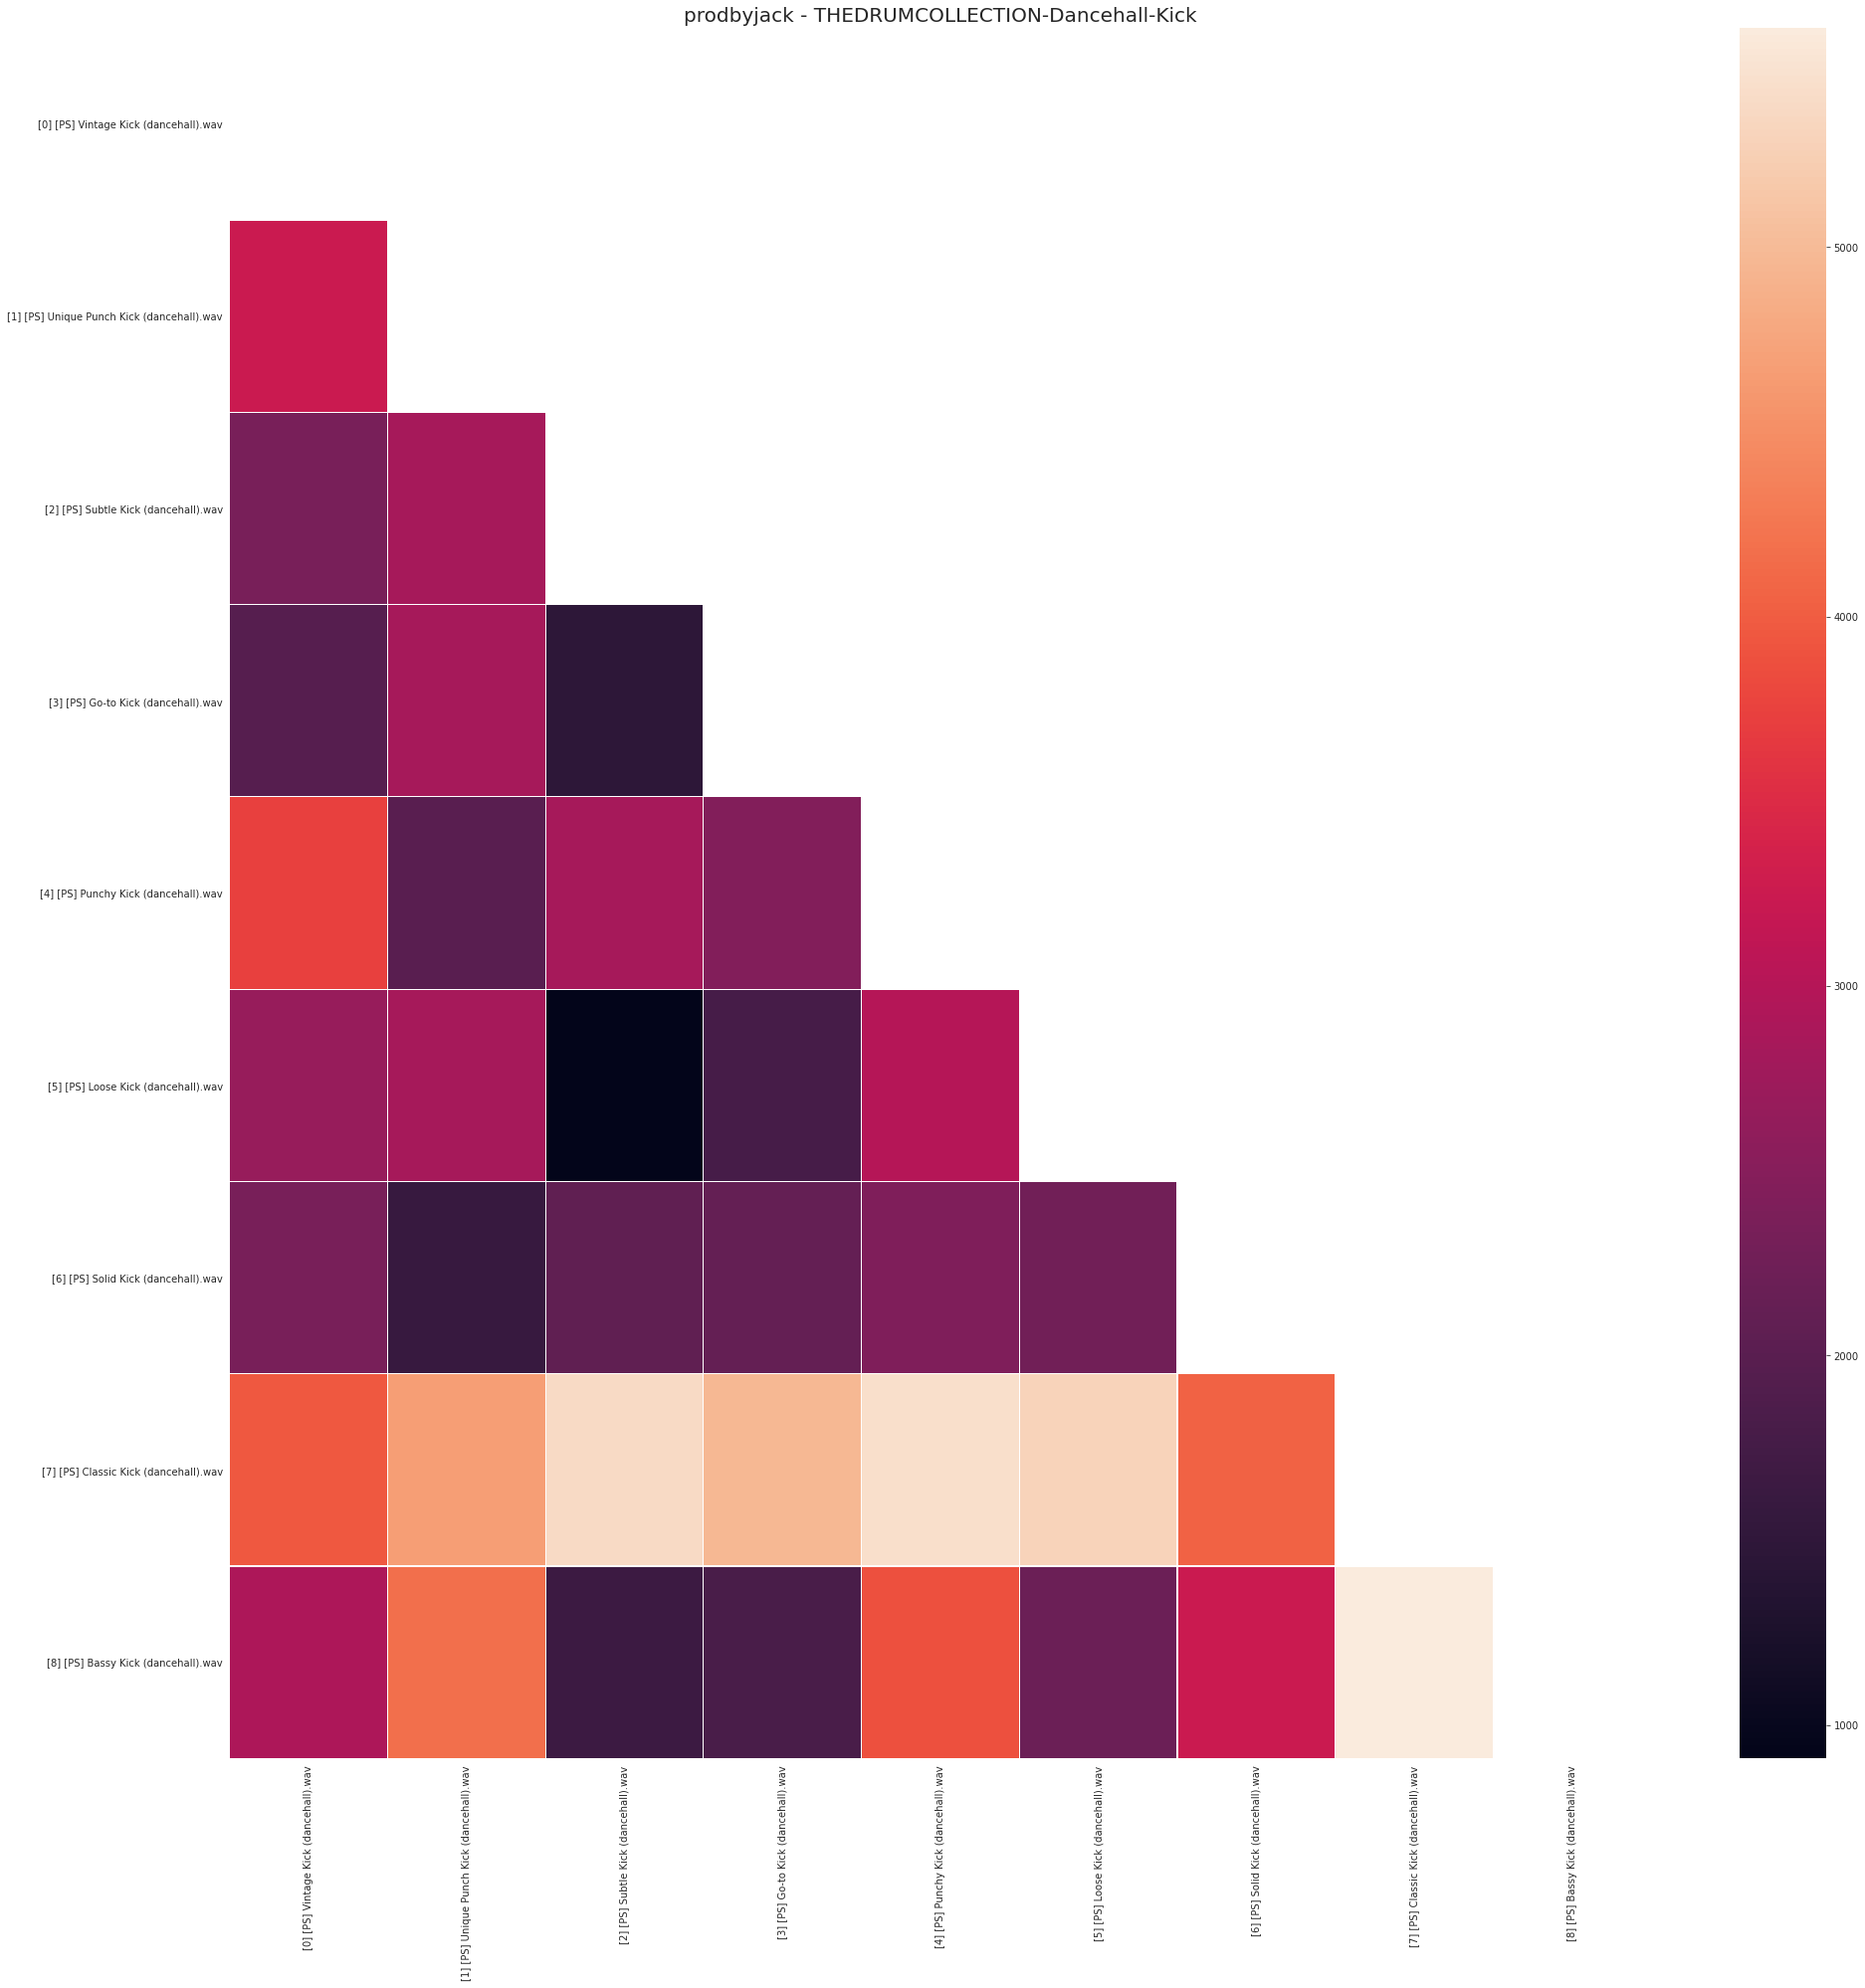

# prodbyjack - THEDRUMCOLLECTION-Dancehall-Hi Hat
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%18%18%18%18%18%18%18%18%18%18%18%18%18%18%18%18%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%81%81%81%81%81%81%81%81%81%81%81%81%81%81%81%81%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%93%93%93%93%93%93%93%93%93%93%93%93%93%93%93%93%

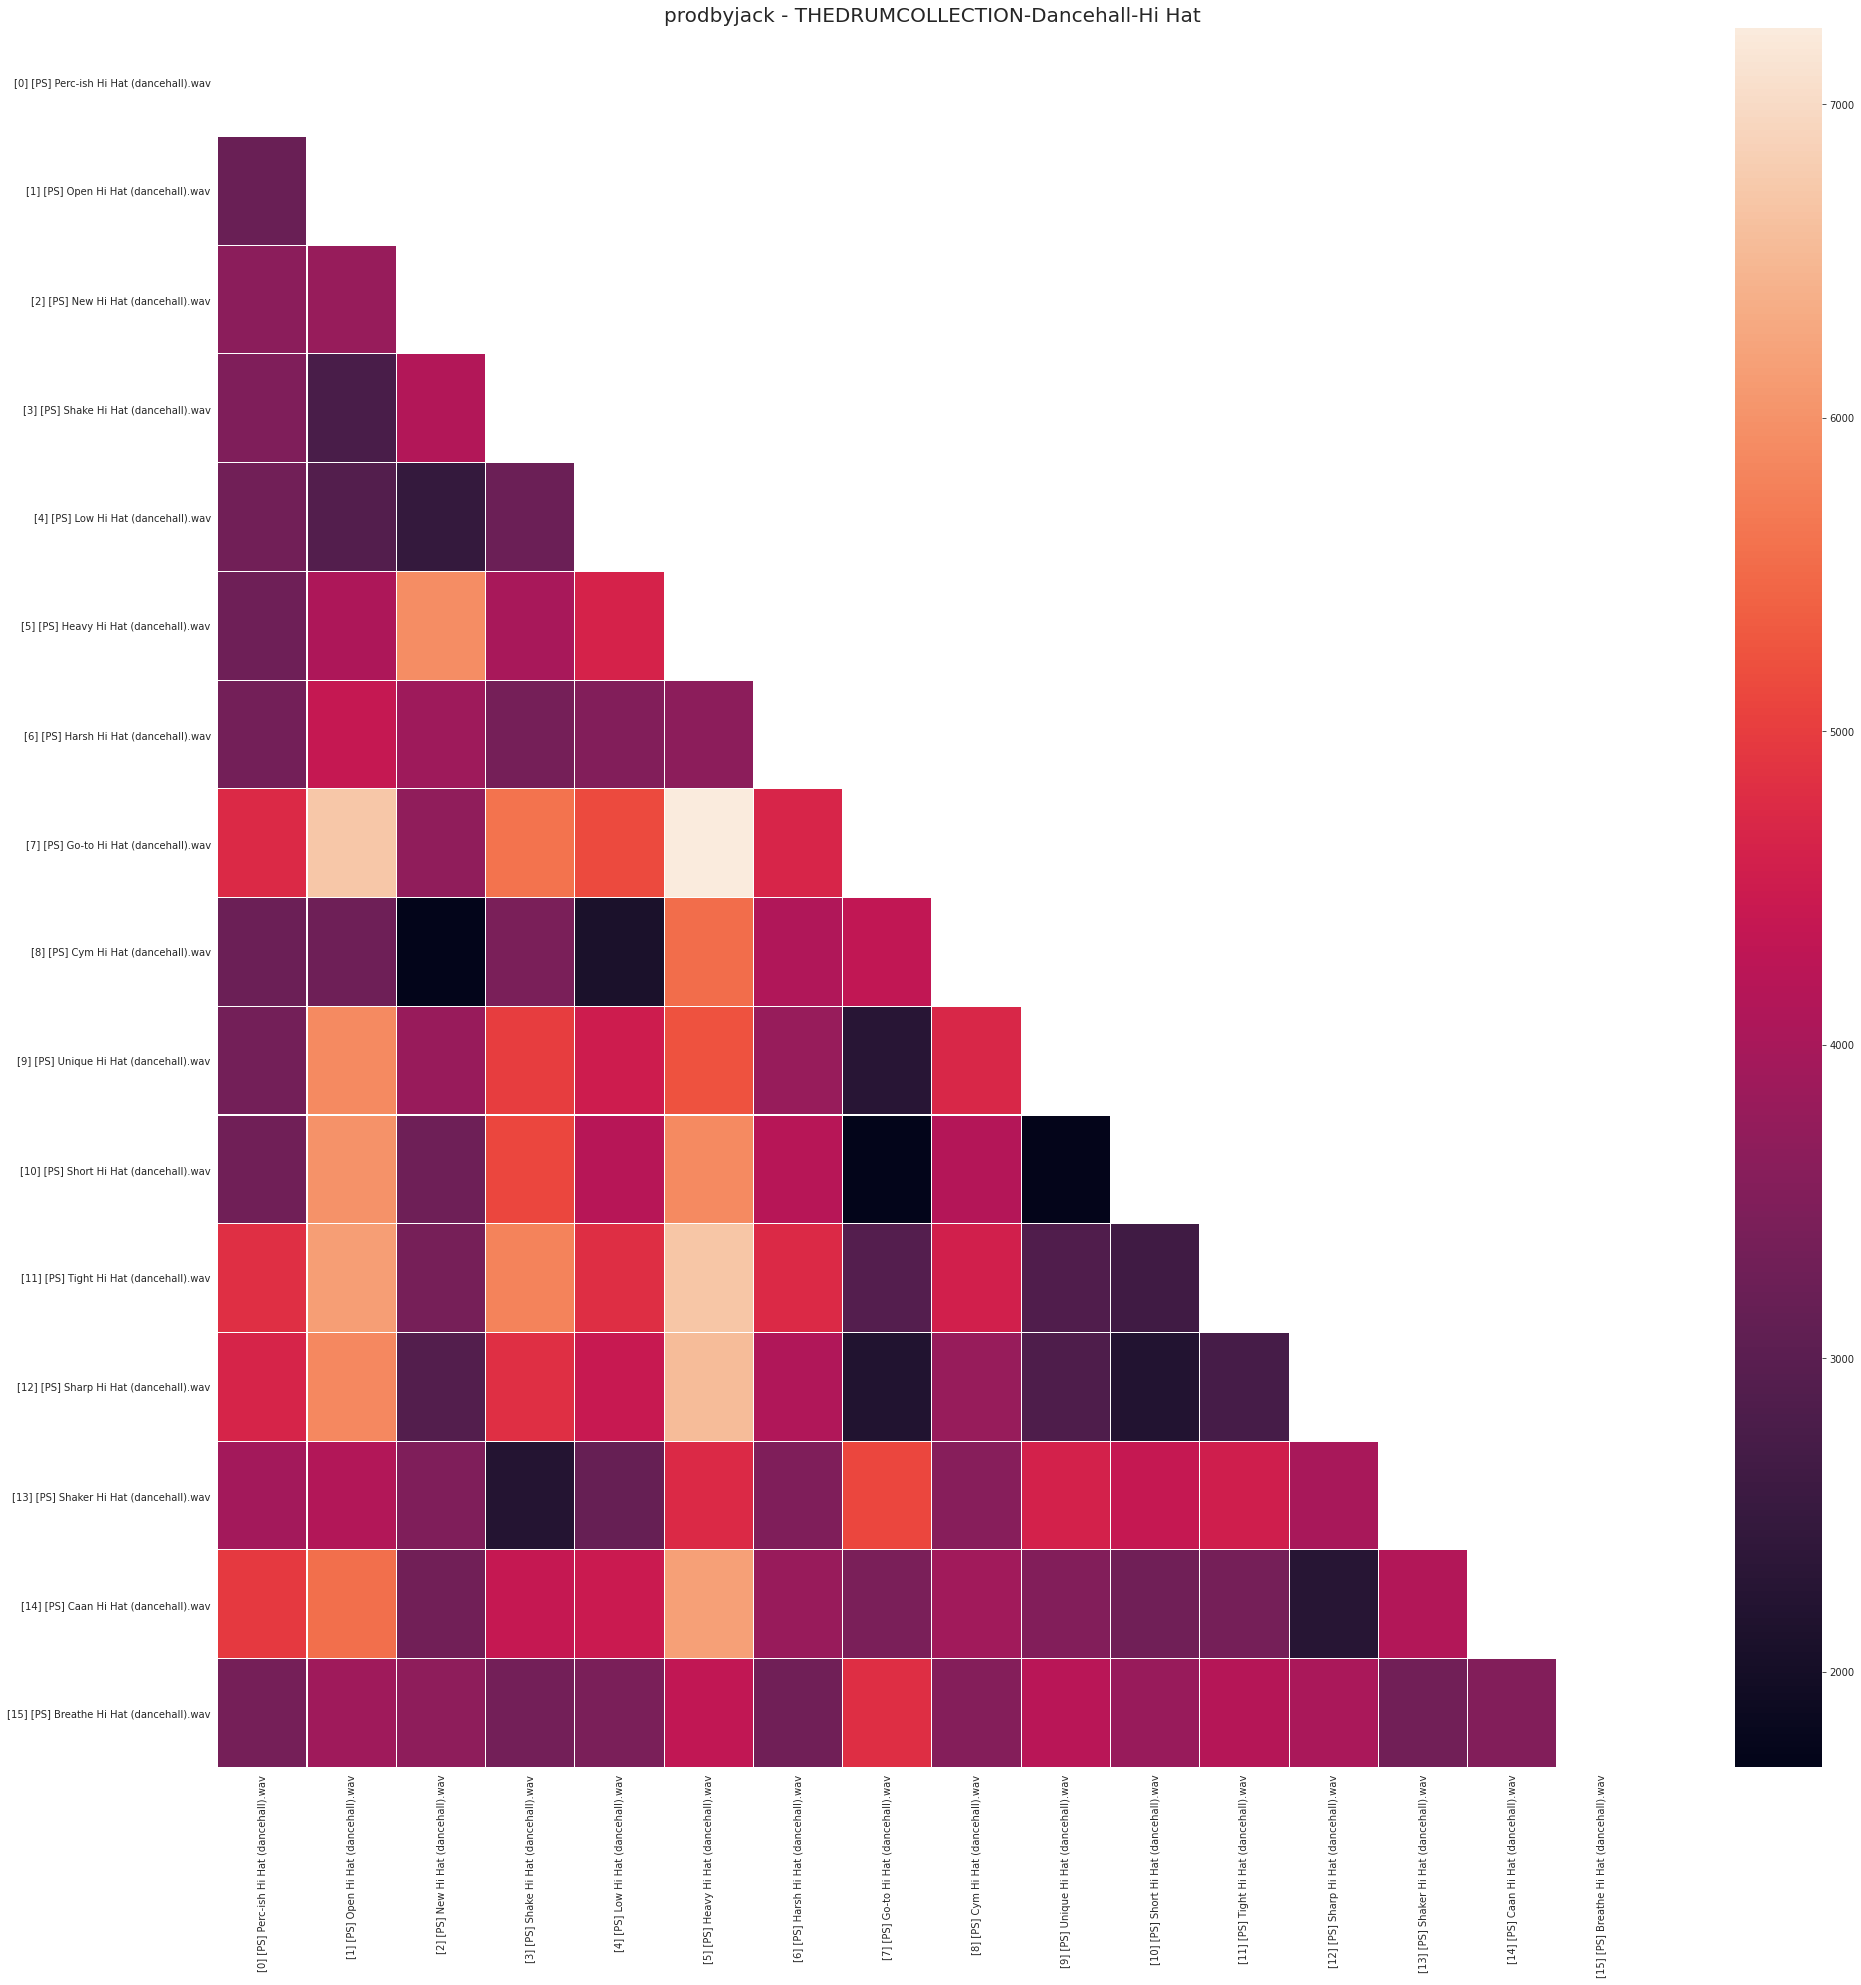

# prodbyjack - THEDRUMCOLLECTION-Dancehall-Fx
0%0%0%0%0%0%0%0%0%0%10%10%10%10%10%10%10%10%10%10%20%20%20%20%20%20%20%20%20%20%30%30%30%30%30%30%30%30%30%30%40%40%40%40%40%40%40%40%40%40%50%50%50%50%50%50%50%50%50%50%60%60%60%60%60%60%60%60%60%60%70%70%70%70%70%70%70%70%70%70%80%80%80%80%80%80%80%80%80%80%90%90%90%90%90%90%90%90%90%90%

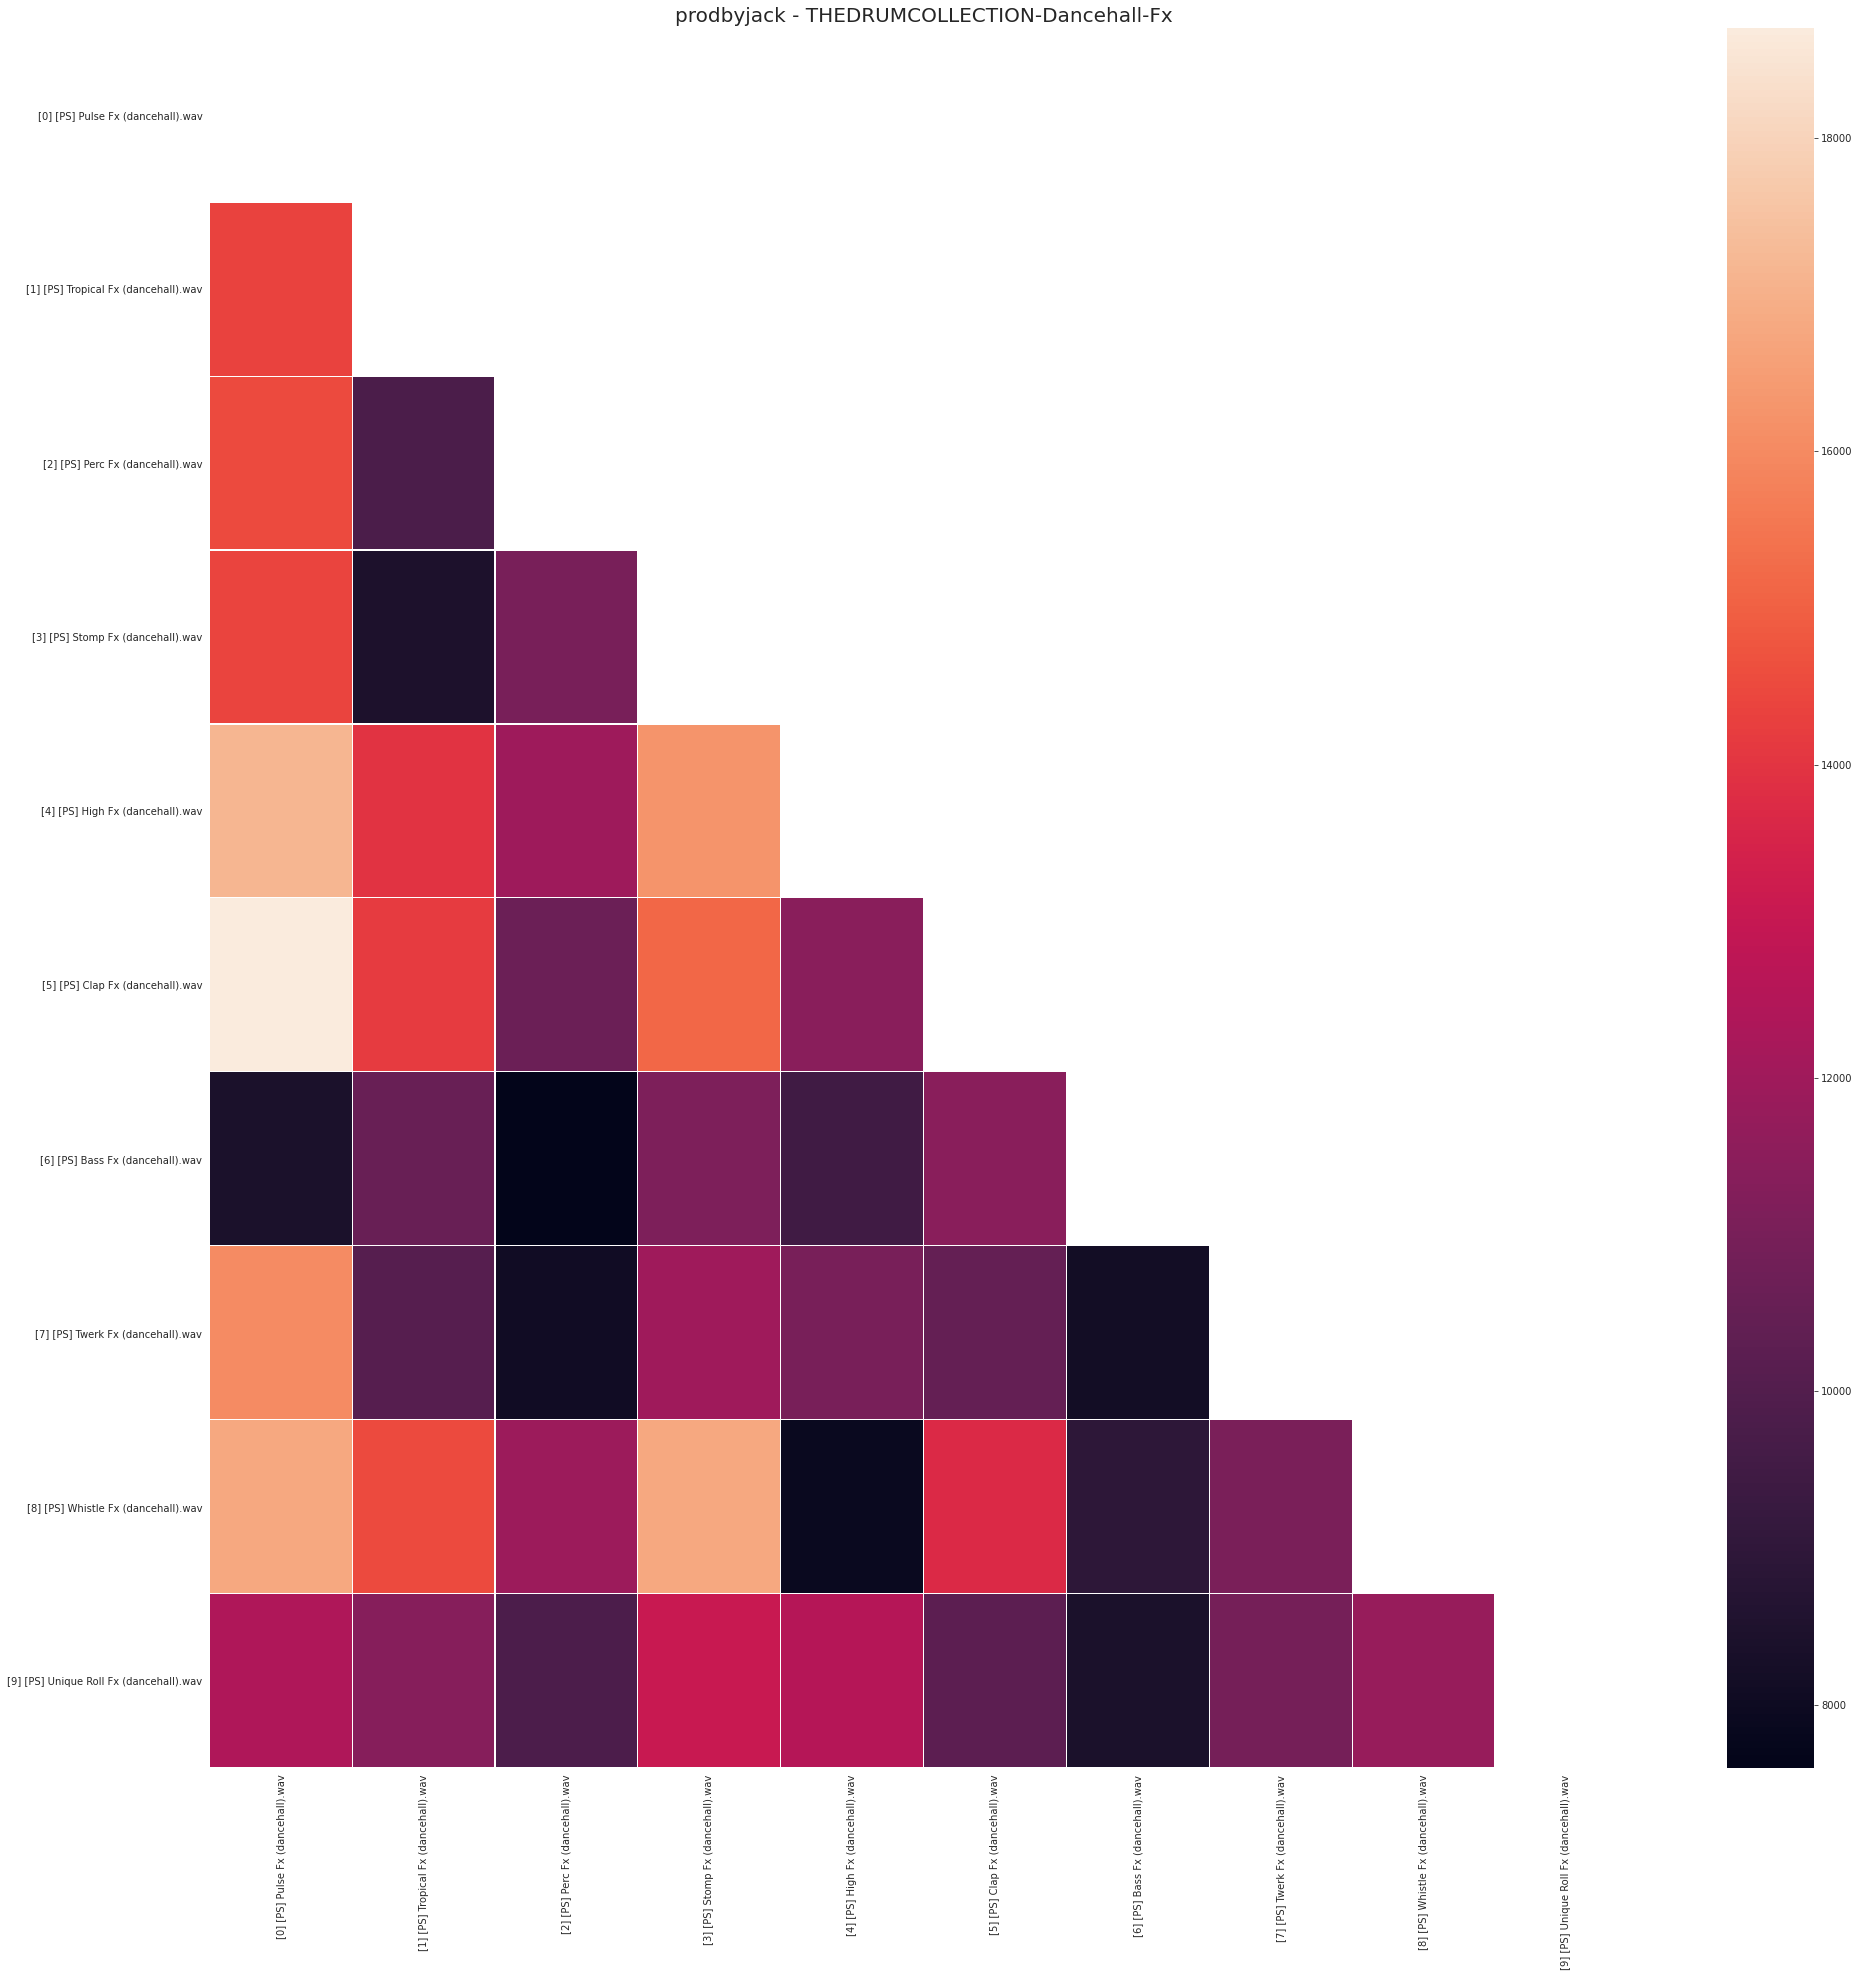

# prodbyjack - THEDRUMCOLLECTION-Dancehall-Clap
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%80%80%80%80%80%80%80%80%80%80%80%80%80%80%80%86%86%86%86%86%86%86%86%86%86%86%86%86%86%86%93%93%93%93%93%93%93%93%93%93%93%93%93%93%93%

In [ ]:
%%time

for dir_drums in get_all_directory(DRUMKIT_LEDOSSIER):
    
    we_title = "-".join(dir_drums.split("/")[-3:] )
    print('#',we_title)
    listeFichiersAUDIO_names, listeFichiersAUDIO = get_names_files_on(dir_drums)
    tab = matrice_similitude_listes_audios(listeFichiersAUDIO)
    CreateHeatMap(tab, listeFichiersAUDIO_names, we_title)

In [33]:
def get_drums_similaires(tab, seuil):
    res = []
    #format_line = '# {:>45} <--> {:>45} : {:>5} '
    for i in range(np.shape(tab)[0]):
        for j in range(np.shape(tab)[1]):
            if j < i:
                if tab[i][j] < seuil:
                    res.append( ( listeFichiersAUDIO_names[i], listeFichiersAUDIO_names[j], round(tab[i][j],1)) ) 
                    #print(format_line.format(listeFichiersAUDIO_names[i],listeFichiersAUDIO_names[j], round(tab[i][j],1))  )
    return res

def print_drums_similaires(res):
    format_line = '# {:>25} <--> {:>25} : {:>5} '
    for i,j, v in res:
        print( format_line.format(i, j, v)  )

def round_bis(value,step = 1):
    inv = 1 /step

    res = round(value * inv) / inv

    if res < value:
        return res + step
    else:
        return res

leSeuil = round_bis(np.nanmin(tab), 500)
leSeuil = leSeuil if leSeuil > 500 else 500
print_drums_similaires(    get_drums_similaires(tab,  leSeuil ))

print("min" , np.nanmin(tab), leSeuil  )

# [8] Go-to Snare (drill).wav <--> [0] [PS] Go-to Snare (drill).wav :  77.9 
# [14] Clean Snare (trap).wav <--> [4] [PS] Clean Snare (trap).wav : 246.7 
# [16] Classic Snare (drill).wav <--> [3] [PS] Classic Snare (drill).wav :  76.8 
# [18] Boxy Snare (trap).wav <--> [12] [PS] Boxy Snare (trap).wav :  77.5 
# [19] Boxy Snare (drill).wav <--> [7] [PS] Boxy Snare (drill).wav :  20.7 
min 20.744806051254272 1000.0


In [35]:
AfficherAudio([listeFichiersAUDIO[8],  listeFichiersAUDIO[0]],  2)